# Web Scraping Data Science Job Postings

Using requests and BeautifulSoup modules from python to scrape jobs from Indeed.com and evaluate/assess/examine technical skills and keywords that are in popular demand by employers right now. 


Assess skills and keywords required for a data scientist role using the requests and BeautifulSoup modules on html data as well as natural language toolking for data mining.

Tags - web scraping, data extraction, indeed.com, requests, beautifulsoup, pandas, matplotlib, regex, nltk 

## Introduction

Overview of the Workflow - 

1. Write a function that takes in a location parameter and return a dataframe with the jobs posted in the last seven days. Each row in the dataframe will contain the job title, company location, rating, whether the job is remote friendly or not and the link to the job posting.

2. Access the link for each job posting in the dataframe and scrape the job description to find how often a given skill is listed in the job postings.


In [602]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
import math
from IPython.core.display import clear_output
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')

In [222]:
from time import time, sleep
from random import randint
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from collections import Counter
from nltk.util import ngrams
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /Users/neha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/neha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Examining the url

Lets take a quick look at indeed.com landing page. We are given two input options - what (which can be a job title, keyword or a company name) and where (location). Lets type `data scientist` and `San Francisco, CA` as the inputs to the search parameters. Here is the link to the website. Note the URL - 


>> https://www.indeed.com/jobs?q=data+scientist&l=San+Francisco%2C+CA&fromage=7

where the `q` and `&l` parameters begin the what and where parameters (each term in seperated by a + and the city and state values are seperated by %2C). The `&fromage` parameter represents the number of jobs posted in the last 7 days.

Lets look at the web addresses of the next two pages of search results - 

>> https://www.indeed.com/jobs?q=data+scientist&l=San+Francisco%2C+CA&fromage=7&start=10

>> https://www.indeed.com/jobs?q=data+scientist&l=San+Francisco%2C+CA&fromage=7&start=20

As we can see, the `&start` parameter is added for page 2 and beyond with values in multiples of 10, e.g. '10', '20', etc.

This will be important when we use the requests module to access the search data from the website.

### Examining the page structure



The function `extract_jobs` will scrape anywhere from 2 to 15 pages depending on the number of jobs posted for a city/state in the last 7 days.
If the number of jobs in that location do not encompass 2 pages or more - the function will return None.
If the number of jobs are more than 15 pages long - it will only scrape to 15 pages
To ensure that I do not request all pages one after another - I have added the time.sleep method
Add extra headers related to page numbers (&page=10,20,30 etc for page 2,3,4 etc)
Make sure I am only doing max 15 requests to the website

Most of the searches gives ~15 jobs per page this will give me anywhere from 15\*2 = 20 to 15\*15 = 225 jobs. 

In [533]:
def extract_jobs(location = None):
    """
    Returns a dataframe of Data Scientist jobs posted within the last 7 days at location

    Extended description of function.

    Parameters
    ----------
    location : str
        The location for the job search. Can also be left blank
        Example accepted values for the parameter:
        <City name>, <State abbreviation>: Lexington, KY
        <State name or abbreviation>: Kentucky or KY
        <Country name>: United States
        <Remote>
        
    Returns
    -------
    DataFrame
        A dataframe where each row represents one job in the specified location. The df will have the following 
        columns: Job title, Company name, Company location, is_remote, Job_Salary, Job_url, Job_summary

    """
    
    job_titles = []
    job_urls = []
    company_names = []
    ratings = []
    locations = []
    is_remote = []
    salaries = []
    summaries = []

    if location is not None:
        if location.find(',') != -1:
            location = location.replace(',','')
            state = location[-2:]
            city = location[:len(location)-2]
            city = city.split()
            city = '+'.join(city)
            print(city)
            print(state)
            url = 'https://www.indeed.com/jobs?q=data+scientist' + '&l=' + city + '%2C'+ state + '&fromage=7'
        elif location.find(',') == -1:
            print('no city')
            location = location.split()
            location = '+'.join(location)
            print(location)
            url = 'https://www.indeed.com/jobs?q=data+scientist' + '&l=' + location + '&fromage=7'
    else:
        url = 'https://www.indeed.com/jobs?q=data+scientist' + '&fromage=7'
    
    print(url)
    print('Getting the first page....')
    response = requests.get(url)
    print('Response code: {}' .format(response.status_code))
    parser = BeautifulSoup(response.content, 'html.parser')
    job_containers = parser.find_all('div', class_ ="jobsearch-SerpJobCard")
    print('No of jobs in page 1: {}'.format(len(job_containers)))
    
    
    total_jobs_tag = parser.find('div', id='searchCountPages')
    if total_jobs_tag is not None:
        total_jobs_str = total_jobs_tag.text.strip()
        total_jobs = int(re.findall(r'\d+', total_jobs_str.replace(',',''))[-1])
        print('Total number of jobs found: {}' .format(total_jobs))
    else:
        print('very few jobs found. Please try a different city')
        return
    
    pages = math.ceil(total_jobs/len(job_containers))
    print('Total number of pages to scrape: {}' .format(pages))
    
    if pages < 2:
        print('Not enough jobs to scrape. Please try a different city.')
        return
    elif pages > 15:
        print('Too many pages to scrape. Will limit to 15 pages')
        pages = 15
        
    page_range = [str(i)+'0' for i in range(1,pages)]
    print(page_range)

    for page in page_range:
        #first get the page 0 info that is already parsed
        if response.status_code == 200:
            for job in job_containers:
                title = job.h2.a['title']
                job_titles.append(title)
    
                url = job.h2.a['href']
                job_urls.append(url)
    
                name = job.find(class_="company")
                company_names.append(name.text.strip())
    
                rating = job.find(class_='ratingsContent')
                ratings.append(rating.text.strip() if rating is not None else None)
        
                location = job.find(class_="location accessible-contrast-color-location")
                locations.append(location.text.strip() if location is not None else None)
        
                remote = job.find(class_='remote')
                is_remote.append(remote.text.strip() if remote is not None else None)
    
                salary = job.find(class_='salaryText')
                salaries.append(salary.text.strip() if salary is not None else None)
    
                summary = job.find(class_='summary')
                summaries.append(summary.text.strip())    
        else:
            print('status code not valid...moving onto next page')
        
        #wait 5-15 seconds before the next request
        start_time = time()
        sleep(randint(5,15))
        elapsed_time = time()-start_time
        print('Elapsed time: {}' .format(elapsed_time))
        
        #new url for page 2 and beyond
        url = 'https://www.indeed.com/jobs?q=data+scientist&l=Remote&fromage=7' + '&start=' + page
        print('Getting jobs from page {}'.format(int(page[:-1])+1))
        response = requests.get(url)
        print('Status Code', response.status_code)
        parser = BeautifulSoup(response.content, 'html.parser')
        job_containers = parser.find_all('div', class_ ="jobsearch-SerpJobCard")
    
    indeed_jobs_df = pd.DataFrame(
        {
            'Job title': job_titles,
            'Company name': company_names,
            'Company rating': ratings,
            'Company location': locations,
            'is_remote': is_remote,
            'Salary range': salaries,
            'Job summary': summaries,
            'url': job_urls
        }
    )
        
    return indeed_jobs_df

usa_jobs_df = extract_jobs('United States')

no city
United+States
https://www.indeed.com/jobs?q=data+scientist&l=United+States&fromage=7
Getting the first page....
Response code: 200
No of jobs in page 1: 15
Total number of jobs found: 1153
Total number of pages to scrape: 77
Too many pages to scrape. Will limit to 15 pages
['10', '20', '30', '40', '50', '60', '70', '80', '90', '100', '110', '120', '130', '140']
Elapsed time: 5.007459878921509
Getting jobs from page 2
Status Code 200
Elapsed time: 10.001575946807861
Getting jobs from page 3
Status Code 200
Elapsed time: 9.003044843673706
Getting jobs from page 4
Status Code 200
Elapsed time: 5.0012900829315186
Getting jobs from page 5
Status Code 200
Elapsed time: 10.00547194480896
Getting jobs from page 6
Status Code 200
Elapsed time: 12.001566886901855
Getting jobs from page 7
Status Code 200
Elapsed time: 6.000251770019531
Getting jobs from page 8
Status Code 200
Elapsed time: 10.003504753112793
Getting jobs from page 9
Status Code 200
Elapsed time: 9.005317211151123
Getting 

The output of this function is stored in `usa_jobs_df` dataframe.

## Exploratory data analysis



In [534]:
display(usa_jobs_df.head())

,Job title,Company name,Company rating,Company location,is_remote,Salary range,Job summary,url
0,Junior Data Scientist,Leidos,3.7,"Pittsburgh, PA 15236",Remote,None,Work individually and on local and geographica...,/pagead/clk?mo=r&ad=-6NYlbfkN0CZUO70VSdYKA8PR3...
1,Data Scientist,Penfield Search Partners,None,"Plainsboro, NJ",None,None,Creates robust models based on statistical and...,/pagead/clk?mo=r&ad=-6NYlbfkN0CqQJ8fSTs6IWaHyu...
2,Healthcare Outcomes Data Scientist,Arine,None,Remote,None,None,This role will involve working with large heal...,/pagead/clk?mo=r&ad=-6NYlbfkN0B9FR8A5Gya-JHhsC...
3,Data Scientist,Epace Technology,None,United States,None,None,"Understanding data, data problem statements, d...",/rc/clk?jk=897be629172f9721&fccid=28cf12cd5277...
4,Jr. Data Scientist,Dash Technologies Inc,None,"Kansas City, KS",None,"$76,029 - $105,000 a year",Work with developers to design algorithms and ...,/company/Dash-Technologies-Inc/jobs/Junior-Dat...


In [535]:
print(usa_jobs_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Job title         199 non-null    object
 1   Company name      199 non-null    object
 2   Company rating    126 non-null    object
 3   Company location  199 non-null    object
 4   is_remote         112 non-null    object
 5   Salary range      25 non-null     object
 6   Job summary       199 non-null    object
 7   url               199 non-null    object
dtypes: object(8)
memory usage: 12.6+ KB
None


In [537]:
usa_jobs_df.isnull().sum()

Job title             0
Company name          0
Company rating       73
Company location      0
is_remote            87
Salary range        174
Job summary           0
url                   0
dtype: int64

The dataframe `usa_jobs_df` contains 155 rows and 8 columns. The column `Salary range` has over 85% null values so we'll ignore it. 

In [539]:
usa_jobs_df['Salary range'].value_counts(dropna=False)

NaN                           174
$35,000 - $60,000 a year        9
$70,315 - $90,405 a year        3
$115,000 - $140,000 a year      3
$75 - $85 an hour               1
$50 - $60 an hour               1
$100,000 - $130,000 a year      1
Up to $180,000 a year           1
$76,029 - $105,000 a year       1
$20 - $25 an hour               1
$100,000 - $125,000 a year      1
$100 - $130 an hour             1
$75,000 - $140,000 a year       1
$102,663 - $157,709 a year      1
Name: Salary range, dtype: int64

Lets change the `Company rating` to numeric data type.

In [540]:
usa_jobs_df['Company rating'] = usa_jobs_df['Company rating'].astype('float')

Column `is_remote` has some null values - which probably represents that the job is not remote. So we will replace the null values with 'not remote'. Before we do that, lets check the `Company location` column to see if it says 'Remote'. if yes, then change 'is_remote' to 'Remote'. 

In [542]:
idx = usa_jobs_df[usa_jobs_df['Company location'] == 'Remote'].index
usa_jobs_df['is_remote'].loc[idx] = 'Remote'

/Users/neha/opt/miniconda3/envs/WebScraping/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [545]:
#Some of the jobs say 'Remote' in the title as well. 
#Lets check those rows to see if it matches with the `is_remote` values - they do

(usa_jobs_df[usa_jobs_df['Job title'].str.contains('[Rr]emote')]['is_remote'] == 'Remote').value_counts()

True    21
Name: is_remote, dtype: int64

In [546]:
#fill missing values in `is_remote` column

usa_jobs_df['is_remote'].fillna(value='Not Remote', inplace=True)
usa_jobs_df['is_remote'].value_counts()

Remote        187
Not Remote     12
Name: is_remote, dtype: int64

If we look carefully at the `url` column, we see that it is missing the base address - http://www.indeed.com
This will be required if we want to access the link. Lets add the base address to all the column values.

In [547]:
usa_jobs_df['url'] = 'https://www.indeed.com' + usa_jobs_df['url']

Lets check now to see if there any duplicate rows in the dataframe. Further inspection of the dataframe tells us that there are some jobs which have exactly the same profiles but different web addresses (ie., the same job can be accessed with different websites). Therefore, we will use a subset of all columns except 'url' to determine what duplicate rows need to be dropped.


- we will look at the job title to see if we can some info about the position - ie, if its entry level or senior level position.


In [548]:
usa_jobs_df[usa_jobs_df.duplicated()]

,Job title,Company name,Company rating,Company location,is_remote,Salary range,Job summary,url
75,Senior Director Statistics,POINT Biopharma,NaN,Remote,Remote,None,Serves as Statistical Lead in clinical trial t...,https://www.indeed.com/rc/clk?jk=c7343120c2b2a...
76,Sr. Machine Learning Engineer (Python),Tiger Analytics,NaN,Remote,Remote,None,An Engineer with 5+ years of experience and wi...,https://www.indeed.com/rc/clk?jk=57ed8f05bffe7...
78,Senior Product Manager Data Platform | AI,Method Resourcing Solutions Ltd,NaN,"Caledonia, WI",Remote,None,Technical background as engineer/data scientis...,https://www.indeed.com/rc/clk?jk=f8630c8b7202c...
79,Senior Software Engineer – Natural Language Pr...,SkySync,5.0,"Ann Arbor, MI",Remote,None,"Up-to-date knowledge of machine learning , nat...",https://www.indeed.com/rc/clk?jk=eea0ced520a60...
80,Principal Statistical Programmer (Remote),Covance,3.2,"Durham, NC 27703",Remote,None,"Excellent organizational, time management and ...",https://www.indeed.com/rc/clk?jk=841e0eb54a233...
...,...,...,...,...,...,...,...,...
194,"Software Engineer, AI Imaging",Change Healthcare,3.0,"Minneapolis, MN",Remote,None,"Assist with data collection efforts, in partic...",https://www.indeed.com/rc/clk?jk=950f26170c005...
195,Principal Statistical Programmer (Ref: RM),PHASTAR,NaN,"Houston, TX",Remote,None,"Responsibility for overall project delivery, i...",https://www.indeed.com/company/Phastar/jobs/Pr...
196,"Software Engineer Intern, Machine Learning (PhD)",Facebook,4.2,Remote,Remote,None,"Research experience in a relevant field, such ...",https://www.indeed.com/rc/clk?jk=692e1d769abf7...
197,Senior Director Statistics,POINT Biopharma,NaN,Remote,Remote,None,Serves as Statistical Lead in clinical trial t...,https://www.indeed.com/rc/clk?jk=c7343120c2b2a...


In [549]:
usa_jobs_df[usa_jobs_df['Company name'] == 'Facebook']

,Job title,Company name,Company rating,Company location,is_remote,Salary range,Job summary,url
72,"Software Engineer Intern, Machine Learning (PhD)",Facebook,4.2,Remote,Remote,None,"Research experience in a relevant field, such ...",https://www.indeed.com/rc/clk?jk=692e1d769abf7...
89,"Software Engineer Intern, Machine Learning (PhD)",Facebook,4.2,Remote,Remote,None,"Research experience in a relevant field, such ...",https://www.indeed.com/rc/clk?jk=692e1d769abf7...
104,"Software Engineer Intern, Machine Learning (PhD)",Facebook,4.2,Remote,Remote,None,"Research experience in a relevant field, such ...",https://www.indeed.com/rc/clk?jk=692e1d769abf7...
115,"Software Engineer Intern, Machine Learning (PhD)",Facebook,4.2,Remote,Remote,None,"Research experience in a relevant field, such ...",https://www.indeed.com/rc/clk?jk=692e1d769abf7...
135,"Software Engineer Intern, Machine Learning (PhD)",Facebook,4.2,Remote,Remote,None,"Research experience in a relevant field, such ...",https://www.indeed.com/rc/clk?jk=692e1d769abf7...
150,"Software Engineer Intern, Machine Learning (PhD)",Facebook,4.2,Remote,Remote,None,"Research experience in a relevant field, such ...",https://www.indeed.com/rc/clk?jk=692e1d769abf7...
160,"Software Engineer Intern, Machine Learning (PhD)",Facebook,4.2,Remote,Remote,None,"Research experience in a relevant field, such ...",https://www.indeed.com/rc/clk?jk=692e1d769abf7...
181,"Software Engineer Intern, Machine Learning (PhD)",Facebook,4.2,Remote,Remote,None,"Research experience in a relevant field, such ...",https://www.indeed.com/rc/clk?jk=692e1d769abf7...
196,"Software Engineer Intern, Machine Learning (PhD)",Facebook,4.2,Remote,Remote,None,"Research experience in a relevant field, such ...",https://www.indeed.com/rc/clk?jk=692e1d769abf7...


In [550]:
usa_jobs_df.drop_duplicates(subset=['Job title', 'Company name', 'Company rating', 'Company location',
                                    'is_remote', 'Salary range', 'Job summary'],
                            keep='last', inplace=True)
usa_jobs_df.shape

(71, 8)

In [551]:
usa_jobs_df[usa_jobs_df['Company name'] == 'Facebook']

,Job title,Company name,Company rating,Company location,is_remote,Salary range,Job summary,url
196,"Software Engineer Intern, Machine Learning (PhD)",Facebook,4.2,Remote,Remote,None,"Research experience in a relevant field, such ...",https://www.indeed.com/rc/clk?jk=692e1d769abf7...


In [553]:
usa_jobs_df.reset_index(inplace=True)  #to reset the index after dropping rows
usa_jobs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             71 non-null     int64  
 1   Job title         71 non-null     object 
 2   Company name      71 non-null     object 
 3   Company rating    45 non-null     float64
 4   Company location  71 non-null     object 
 5   is_remote         71 non-null     object 
 6   Salary range      13 non-null     object 
 7   Job summary       71 non-null     object 
 8   url               71 non-null     object 
dtypes: float64(1), int64(1), object(7)
memory usage: 5.1+ KB


More than half of the rows were duplicates!! We are left with only 71 rows.

Lets clean up the company location column to remove everything except the city and state (or just remote if thats the case). I will create two seperate columns from it - city & state

In [554]:
usa_jobs_df['Company location'].value_counts()

Remote                                      22
Durham, NC 27703                             3
Eden Prairie, MN 55344                       2
Minneapolis, MN                              2
United States                                2
New York, NY                                 2
Ann Arbor, MI                                2
Washington, DC                               1
Denver, CO                                   1
Kansas City, KS                              1
Princeton, NJ 08540                          1
Atlanta, GA 30303 (Five Points area)         1
San Antonio, TX 78288 (Downtown area)        1
Woodbridge, NJ 07095                         1
Plainsboro, NJ                               1
Springfield, VA 22153                        1
Orlando, FL                                  1
San Jose, CA                                 1
Ontario, CA 91764                            1
Overland Park, KS                            1
Fort Meade, MD                               1
Michigan     

In [556]:
def clean_location(loc):
    """
    Returns a series with city and state values given the input location
    """
    split_loc = loc.split(',')
    city = split_loc[0]
    if len(split_loc) > 1:
        state = re.findall(r'[A-Z]{2}',split_loc[1])
        state = ''.join(state)
    else:
        state = split_loc[0]
    return pd.Series([city, state])

#clean_location('Scottsdale, AZ 85250 (South Scottsdale area)')

In [557]:
usa_jobs_df[['City','State']] = usa_jobs_df['Company location'].apply(clean_location)

In [558]:
usa_jobs_df.head()

,index,Job title,Company name,Company rating,Company location,is_remote,Salary range,Job summary,url,City,State
0,0,Junior Data Scientist,Leidos,3.7,"Pittsburgh, PA 15236",Remote,None,Work individually and on local and geographica...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,Pittsburgh,PA
1,1,Data Scientist,Penfield Search Partners,NaN,"Plainsboro, NJ",Not Remote,None,Creates robust models based on statistical and...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,Plainsboro,NJ
2,3,Data Scientist,Epace Technology,NaN,United States,Not Remote,None,"Understanding data, data problem statements, d...",https://www.indeed.com/rc/clk?jk=897be629172f9...,United States,United States
3,4,Jr. Data Scientist,Dash Technologies Inc,NaN,"Kansas City, KS",Not Remote,"$76,029 - $105,000 a year",Work with developers to design algorithms and ...,https://www.indeed.com/company/Dash-Technologi...,Kansas City,KS
4,5,Data Scientist - Entry to Experienced Level,National Security Agency (NSA),4.2,"Fort Meade, MD",Not Remote,"$102,663 - $157,709 a year",Relevant experience must be in designing/imple...,https://www.indeed.com/rc/clk?jk=b3d58051359f6...,Fort Meade,MD


In [559]:
usa_jobs_df['State'].value_counts()

Remote           22
TX                5
MN                5
CA                5
NC                4
NJ                3
GA                3
MI                2
PA                2
NY                2
KS                2
FL                2
United States     2
CO                2
MD                2
MO                1
VA                1
MA                1
DC                1
OH                1
WI                1
KY                1
Michigan          1
Name: State, dtype: int64

There are two rows with `State` = 'United States'. Lets see if we can add them to 'Remote'.

In [576]:
usa_jobs_df[usa_jobs_df['City'] == 'United States']

,index,Job title,Company name,Company rating,Company location,is_remote,Salary range,Job summary,url,City,State,Job Category
2,3,Data Scientist,Epace Technology,NaN,United States,Not Remote,None,"Understanding data, data problem statements, d...",https://www.indeed.com/rc/clk?jk=897be629172f9...,United States,United States,Other
5,6,Data Scientist,Experian,3.7,United States,Remote,None,Develop machine learning algorithms with huge ...,https://www.indeed.com/rc/clk?jk=c5dd5c63190cb...,United States,United States,Other


Looks like we can replace the `City` and `State` values of the second row to Remote. For the first one, we'll leave it as is for now.

In [579]:
usa_jobs_df['State'].loc[5] = 'Remote'

usa_jobs_df['City'].loc[5] = 'Remote'

usa_jobs_df.loc[5]

/Users/neha/opt/miniconda3/envs/WebScraping/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


index                                                               6
Job title                                              Data Scientist
Company name                                                 Experian
Company rating                                                    3.7
Company location                                        United States
is_remote                                                      Remote
Salary range                                                     None
Job summary         Develop machine learning algorithms with huge ...
url                 https://www.indeed.com/rc/clk?jk=c5dd5c63190cb...
City                                                           Remote
State                                                          Remote
Job Category                                                    Other
Name: 5, dtype: object

In [573]:
def title_category(job_title):
    """
    Returns a category for each job title. 
    """
    job_title = re.sub(r'[^\w\s]', ' ', job_title).lower()
    if any(x in job_title for x in ['entry', 'jr.', 'junior']):
        return 'Entry level'
    elif any(x in job_title for x in ['senior', 'sr.', 'lead', 'head', 'manager']):
        return 'Senior level'
    elif 'engineer' in job_title:
        return 'Engineer'
    elif 'intern' in job_title:
        return 'Intern'
    elif 'statistician' in job_title:
        return 'Statistician'
    else:
        return 'Other'
    
usa_jobs_df['Job Category'] = usa_jobs_df['Job title'].apply(title_category)

### Plotting the distributions

Lets plot some of these columns. We will use barplots for categorical variables and histogram for numerical variables.

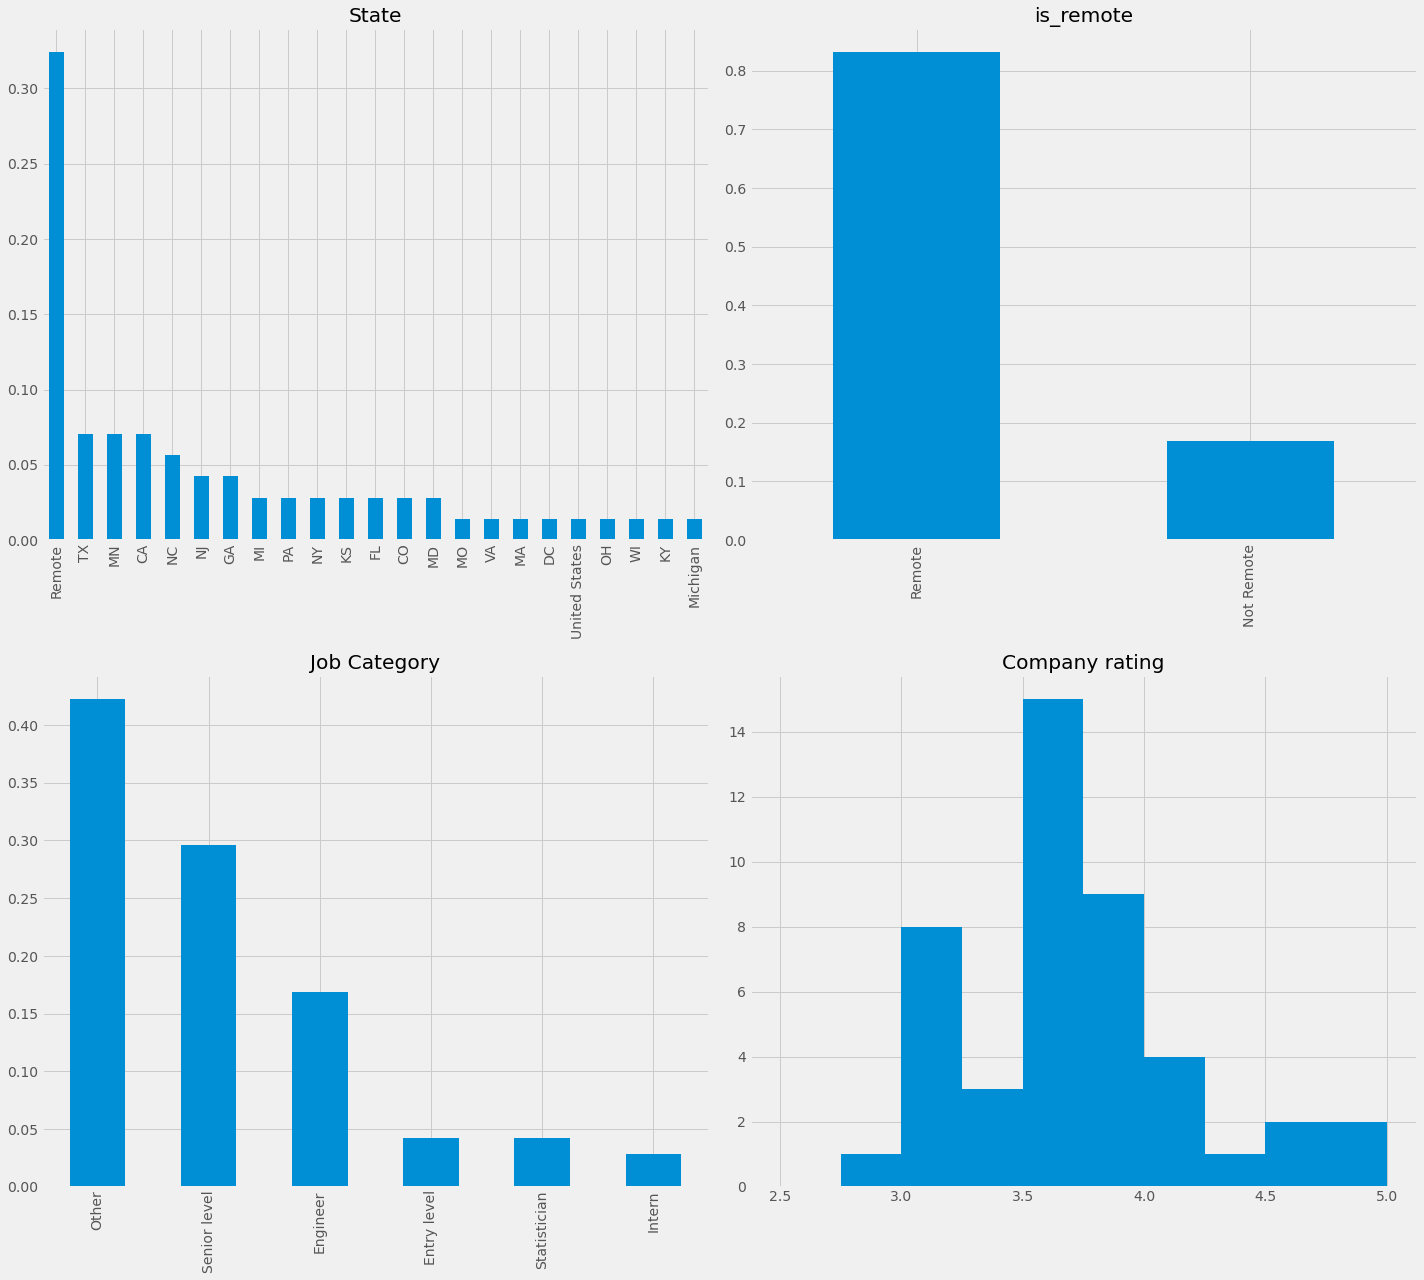

In [605]:
cols = ['State', 'is_remote', 'Job Category', 'Company rating']

fig = plt.figure(figsize=(20,18))
for i,j in enumerate(cols):
    ax = plt.subplot(2,2,i+1)
    if j == 'Company rating':
        usa_jobs_df[j].hist(bins=10, range=(2.5,5), ax=ax)
    else:
        usa_jobs_df[j].value_counts(normalize=True).plot(kind='bar', ax=ax)
    ax.set_title(j)

#plt.suptitle('Distribution of columns in usa_jobs dataframe')
plt.tight_layout()

The next function will take the web address from each row of the usa_jobs_df dataframe and scrape it to get the full description of the job.

In [606]:
def job_description(url):
    try:
        n = randint(5,15)
        sleep(n)  #to avoid bombarding the website with continuous requests
        response = requests.get(url)
        if not response:
            print('connection was not successful')
            return None
        print('Connection successful.....parsing url = {}' .format(url))
        clear_output(wait=True)
        page_html = BeautifulSoup(response.content, 'html.parser')
        #page = page_html.find_all(['p','li'], class_ = 'jobsearch-jobDescriptionText')
        page = page_html.find_all(class_ = 'jobsearch-jobDescriptionText')
        job_description = [j.text for j in page]
        job_description = ' '.join(job_description)
        #print(job_description)
        return job_description
    except requests.exceptions.MissingSchema as noschema:
        print(noschema)
        return

In [607]:
usa_jobs_df['Job Description'] = usa_jobs_df['url'].apply(job_description)

Connection successful.....for url = https://www.indeed.com/rc/clk?jk=57ed8f05bffe76cb&fccid=cba01270e96bb012&vjs=3


In [608]:
usa_jobs_df.head()

,index,Job title,Company name,Company rating,Company location,is_remote,Salary range,Job summary,url,City,State,Job Category,Job Description
0,0,Junior Data Scientist,Leidos,3.7,"Pittsburgh, PA 15236",Remote,None,Work individually and on local and geographica...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,Pittsburgh,PA,Entry level,Description\nJob Description:\nLeidos is a For...
1,1,Data Scientist,Penfield Search Partners,NaN,"Plainsboro, NJ",Not Remote,None,Creates robust models based on statistical and...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,Plainsboro,NJ,Other,Salary: commensurate with experience\nReferenc...
2,3,Data Scientist,Epace Technology,NaN,United States,Not Remote,None,"Understanding data, data problem statements, d...",https://www.indeed.com/rc/clk?jk=897be629172f9...,United States,United States,Other,Only On W2 Accepted.\n\nJob Description:\nLook...
3,4,Jr. Data Scientist,Dash Technologies Inc,NaN,"Kansas City, KS",Not Remote,"$76,029 - $105,000 a year",Work with developers to design algorithms and ...,https://www.indeed.com/company/Dash-Technologi...,Kansas City,KS,Other,Dash Technologies is an industry-leading softw...
4,5,Data Scientist - Entry to Experienced Level,National Security Agency (NSA),4.2,"Fort Meade, MD",Not Remote,"$102,663 - $157,709 a year",Relevant experience must be in designing/imple...,https://www.indeed.com/rc/clk?jk=b3d58051359f6...,Fort Meade,MD,Entry level,NSA is in search of Computer Science professio...


Now that we have the full job descriptions, we will use it to figure out important keywords and skills required by these companies.

In [609]:
def parsing_data(job_description):
    data_counter = Counter()
    job_description = re.sub(r'C\+{2}', 'Cplusplus', job_description)
    job_description = re.sub(r'A[\s]*\/[\s]*B', 'AB', job_description)
    job_description = re.sub(r'[^\w\s]', '', job_description) 
    job_description = re.sub(r'\d', '', job_description)
    #print(job_description)
    tokens = nltk.word_tokenize(job_description.lower())
    cleaned_tokens = [word for word in tokens if word not in set(stopwords.words('english'))]
    #print(cleaned_tokens)
    data_counter.update(cleaned_tokens)
    two_tokens = list(ngrams(cleaned_tokens, 2))
    two_tokens = [" ".join(word) for word in two_tokens]
    #print(two_tokens)
    data_counter.update(two_tokens)
    return data_counter

count = usa_jobs_df['Job Description'].apply(parsing_data)

In [610]:
all_descriptions = Counter()
for i in count:
    all_descriptions.update(set(i))

In [611]:
all_descriptions['analytics']

27

In [612]:
langs_tools_dict = {
    'Python': all_descriptions['python'],
    'R': all_descriptions['r'],
    'SQL': all_descriptions['sql'],
    'NoSQL': all_descriptions['nosql'],
    'Mongodb': all_descriptions['mongodb'],
    'Java': all_descriptions['java'] + all_descriptions['javascript'],
    'C++': all_descriptions['cplusplus'],
    'Matlab': all_descriptions['matlab'],
    'Excel': all_descriptions['excel'],
    'Tableau': all_descriptions['tableau'],
    'SAS': all_descriptions['sas'],
    'SPSS': all_descriptions['spss'],
    'Hadoop': all_descriptions['hadoop'],
    'PySpark': all_descriptions['pyspark'] + all_descriptions['spark'],
    'Tensorflow': all_descriptions['tensorflow'],
    'Scala': all_descriptions['scala'],
    'AWS': all_descriptions['aws'],
    'Azure': all_descriptions['azure'],
    'Github': all_descriptions['github']
    }

techskills_dict = {
    'AI': all_descriptions['ai'] + all_descriptions['artificial intelligence'],
    'A/B testing': all_descriptions['ab testing'],
    'algorithms': all_descriptions['algorithms'] + all_descriptions['algorithm'],
    'business intelligence': all_descriptions['business intelligence'] + all_descriptions['bi'],
    'computer science': all_descriptions['computer science'],
    'engineering': all_descriptions['engineering'],
    'machine learning': all_descriptions['machine learning'] + all_descriptions['ml'],
    'deep learning': all_descriptions['deep learning'],
    'regression': all_descriptions['regression'],
    'classification': all_descriptions['classification'],
    'data visualization': all_descriptions['data visualization'] + all_descriptions['data visualizations'],
    'data exploration': all_descriptions['data exploration'], 
    'statistics': all_descriptions['statistics'],
    'database management': all_descriptions['database management'],
    'database': all_descriptions['database'] + all_descriptions['databases'],
    'big data': all_descriptions['big data'],
    'modeling': all_descriptions['modeling'],
    'mining': all_descriptions['mining'],
    'NLP': all_descriptions['nlp']
    
}

soft_skills = {
    'communication skills': all_descriptions['communication skills'],
    'presentation': all_descriptions['presentation'],
    'reporting': all_descriptions['reporting'],
    'research': all_descriptions['research'],
    'critical thinking': all_descriptions['critical thinking'],
    'analytical': all_descriptions['analytical']    
}

In [613]:
key_skills = langs_tools_dict
key_skills.update(techskills_dict)
key_skills.update(soft_skills)

key_skills_df = pd.DataFrame(key_skills.items(), columns=['keywords', 'count'])
key_skills_df.sort_values(by='count', ascending=False)

,keywords,count
25,machine learning,55
0,Python,40
24,engineering,37
41,research,32
31,statistics,30
19,AI,26
2,SQL,26
23,computer science,26
35,modeling,25
1,R,24


In [617]:
key_skills_df['percent_count'] = (key_skills_df['count']/len(usa_jobs_df))*100
key_skills_df.sort_values(by='percent_count', ascending=False, inplace=True)
key_skills_df.head()

,keywords,count,percent_count
25,machine learning,55,77.464789
0,Python,40,56.338028
24,engineering,37,52.112676
41,research,32,45.070423
31,statistics,30,42.253521


<AxesSubplot:xlabel='keywords'>

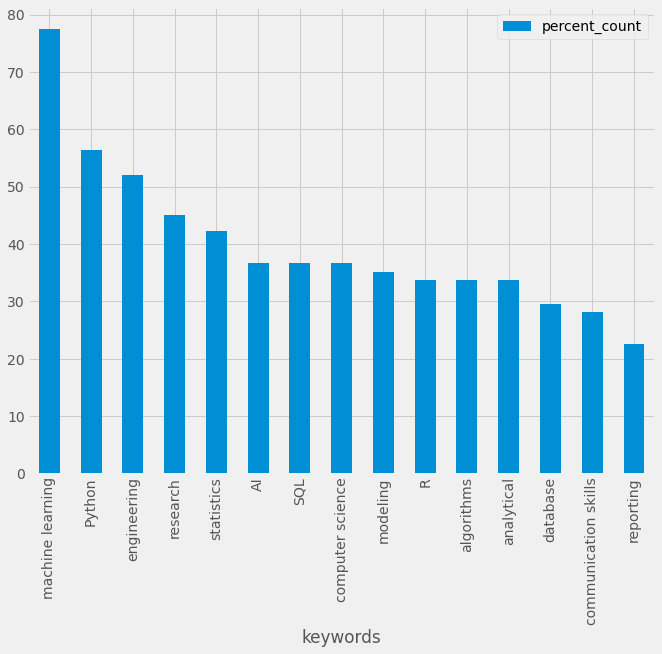

In [615]:
key_skills_df.head(15).plot(x='keywords', y='percent_count', kind='bar', figsize=(10,8))

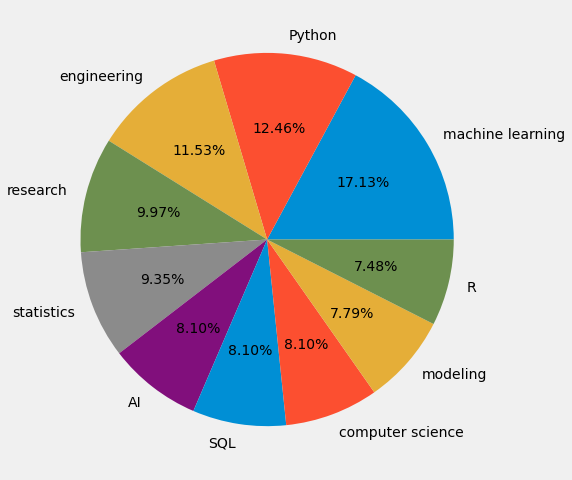

In [616]:
plt.figure(figsize=(10,8))
plt.pie(key_skills_df['percent_count'].head(10), 
        labels=key_skills_df['keywords'].head(10),
        autopct='%1.2f%%')
plt.show()

In [618]:
usa_jobs_df.to_csv('usa_jobs.csv')